# Aperiodic Methods: Spectral Fitting

This notebook demonstrates spectral fitting methods for measuring aperiodic or 1/f-like properties in neural time series.

Implementations of these methods are available in apm/fit.py. This module uses a standardized API and is the recommended way to apply these methods - this notebook is just for demonstration. 

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.optimize import curve_fit
from sklearn.linear_model import RANSACRegressor

from fooof import FOOOF
from fooof.core.funcs import expo_nk_function as expf

In [2]:
# Import custom code
import sys; from pathlib import Path
sys.path.append(str(Path('..').resolve()))

from apm.plts.psd import plt_psd_1, plt_psd_2, plt_psd_shade
from apm.utils import exclude_spectrum

### Example PSD

Load an example PSD, from eyes closed, resting state EEG data, extracted to the range of 3-40 Hz. 

In [3]:
# Load an example power spectrum to check fitting with
freqs = np.load('data/freqs.npy')
psd = np.load('data/psd.npy')

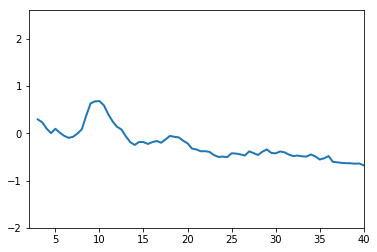

In [4]:
# Check a plot of the PSD
plt_psd_1(freqs, psd, False)

## Check FOOOF Fit of Data

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 40 Hz                        
                                 Frequency Resolution is 0.50 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                          0.5498, 0.6997                                          
                                                                                                  
                                       2 peaks were found:                                        
          

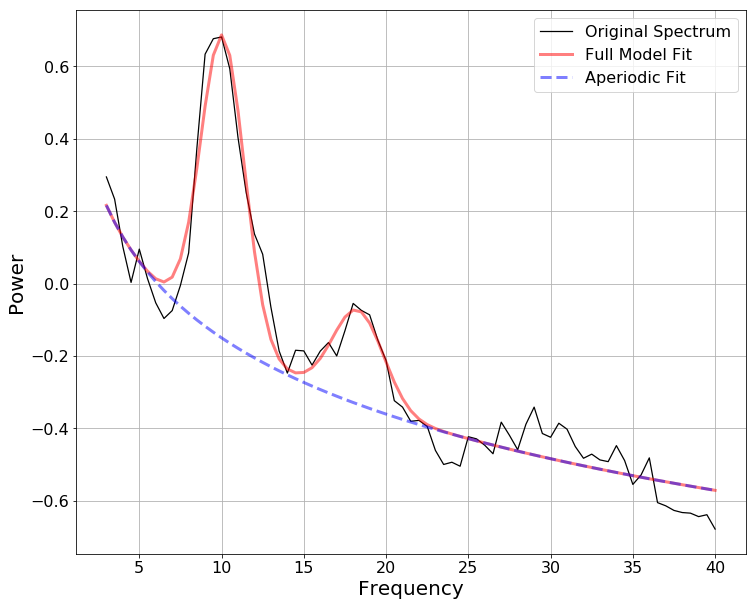

In [5]:
# Initialize FOOOF model
fm = FOOOF(peak_width_limits=[1, 8])

# Fit FOOOF
fm.report(freqs, psd, [3, 40])
res_fooof = -fm.aperiodic_params_[1]

# Methods for Fitting Power Spectra

Words, words, words.

## Linear Fits (in log-log)

In [6]:
# Add constant for fitting with statsmodels
fx = sm.add_constant(np.log10(freqs))

### Simple Linear Fit

Fit with Ordinary Least Squares (OLS)

In [7]:
# Spectral fit: simple linear fit
fit_ols = sm.OLS(np.log10(psd), fx).fit()
res_ols = fit_ols.params[1]

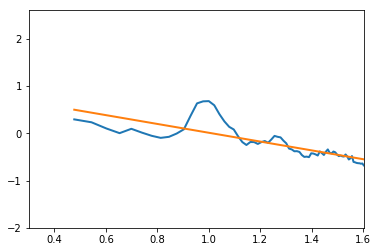

In [8]:
# Check the simple linear fit
plt_psd_2(freqs, psd, freqs, np.power(10, fit_ols.fittedvalues), log_f=True)

### Robust Fit with RLM

In [9]:
# Spectral fit: robust linear fit to log-log PSD
fit_rlm = sm.RLM(np.log10(psd), fx).fit()
res_rlm = fit_rlm.params[1]

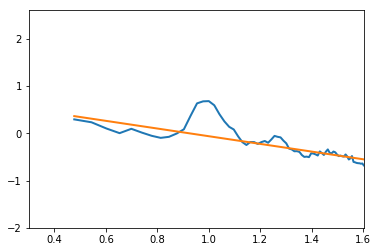

In [10]:
# Check the robust linear fit
plt_psd_2(freqs, psd, freqs, np.power(10, fit_rlm.fittedvalues), log_f=True)

### Robust Fit with RANSAC

In [11]:
# Reshape freqs for RANSAC fit
freqs = freqs.reshape([len(freqs), 1])

In [12]:
# Initialize and fit with RANSAC
ransac_model = RANSACRegressor()
ransac_model.fit(np.log10(freqs), np.log10(psd))
res_ran = ransac_model.estimator_.coef_[0]

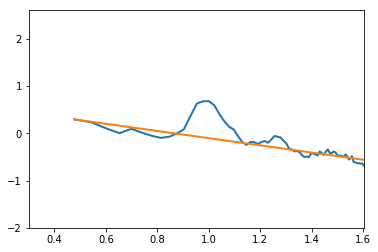

In [13]:
# Plot the fit, from RANSAC
plt_psd_2(freqs, psd, freqs, np.power(10, ransac_model.predict(np.log10(freqs))))

## Spectral Fitting Excluding Alpha

In [14]:
# Exclude predefined alpha range
freqs_alph, psd_alph = exclude_spectrum(np.squeeze(freqs), psd, [7, 14])#, False)

# Reset freqs, with constant
fx = sm.add_constant(np.log10(freqs_alph))

### Robust Fit with RLM Excluding Generic Alpha Band

In [15]:
# Robust fit without alpha range
fit_rlm_alph = sm.RLM(np.log10(psd_alph), fx).fit()
res_rlm_alph = fit_rlm_alph.params[1]

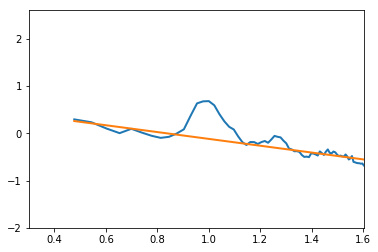

In [16]:
# Plot the fit, with alpha exclusion range (note plots original PSD with alpha included)
plt_psd_2(freqs, psd, freqs_alph, np.power(10, fit_rlm_alph.fittedvalues), log_f=True)

### Robust Fit with RANSAC Excluding Generic Alpha Band

In [17]:
# Fit alpha-exclusion with RANSAC
ransac_model_alph = RANSACRegressor()
ransac_model_alph.fit(np.log10(freqs_alph), np.log10(psd_alph))
res_ran_alph = ransac_model_alph.estimator_.coef_[0][0]

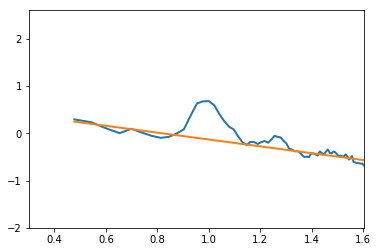

In [18]:
# Plot the fit, with osc excluded (note: plots original spectrum with oscs included)
plt_psd_2(freqs, psd, freqs_alph, np.power(10, ransac_model_alph.predict(np.log10(freqs_alph))))

## Spectral Fit Excluding Oscillations

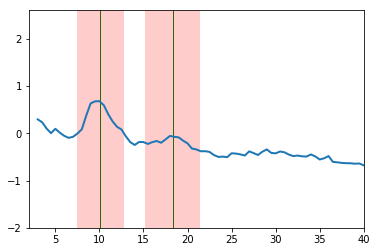

In [19]:
# Get oscillation definitions from FOOOF
cens = fm.gaussian_params_[:, 0]
bws = fm.gaussian_params_[:, 2]

# Plot PSD with oscillatory regions marked out
m = 2
plt_psd_shade(freqs, psd, cens, bws, m)

In [20]:
# Exclude FOOOF oscillation bands
psd_excl = psd
freqs_excl = np.squeeze(freqs)

for cen, bw in zip(cens, bws):
    freqs_excl, psd_excl = exclude_spectrum(freqs_excl, psd_excl, [cen-m*bw, cen+m*bw])

### Robust Fit with RLM Excluding Oscillatory Bands

In [21]:
# Robust fit without FOOOF oscillation bands
fx = sm.add_constant(np.log10(freqs_excl))
fit_rlm_excl = sm.RLM(np.log10(psd_excl), fx).fit()
res_rlm_excl = fit_rlm_excl.params[1]

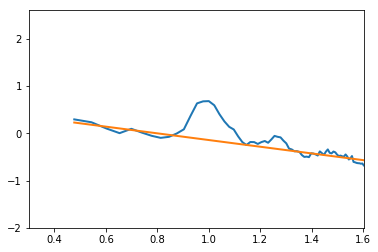

In [22]:
# Plot the fit, with osc excluded (note: plots original PSD with oscs included)
plt_psd_2(freqs, psd, freqs_excl, np.power(10, fit_rlm_excl.fittedvalues), log_f=True)

### Robust Fit with RANSAC Excluding Oscillatory Bands

In [23]:
# Fit alpha-exclusion with RANSAC
ransac_model_excl = RANSACRegressor()
ransac_model_excl.fit(np.log10(freqs_excl), np.log10(psd_excl))
res_ran_excl = ransac_model_excl.estimator_.coef_[0][0]

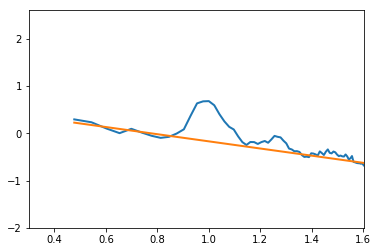

In [24]:
# Plot the fit, with osc excluded (note: plots original PSD with oscs included)
plt_psd_2(freqs, psd, freqs_excl, np.power(10, ransac_model_excl.predict(np.log10(freqs_excl))))

## Exponential Fits

### Exponential Fit

In [25]:
# Fit exponential 1/f, with scipy curve_fit
fit_exp, _ = curve_fit(expf, np.squeeze(freqs), np.squeeze(np.log10(psd)), p0=[1, 1])
res_exp = -fit_exp[1]

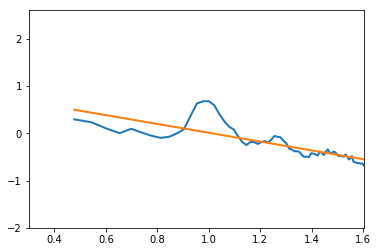

In [26]:
# Plot the fit, from exponential fit
plt_psd_2(freqs, psd, freqs, np.power(10, expf(freqs, *fit_exp)))

### Exponential Fit Excluding Alpha Region

In [27]:
# Fit exponential 1/f, with scipy curve_fit, excluding alpha range
fit_exp_alph, _ = curve_fit(expf, np.squeeze(freqs_alph), np.squeeze(np.log10(psd_alph)), p0=[1, 1])
res_exp_alph = -fit_exp_alph[1]

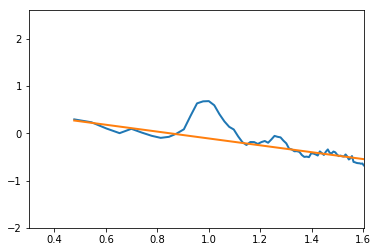

In [28]:
# Plot the fit, from alpha region excluded fit (note: plots original PSD with oscs included)
plt_psd_2(freqs, psd, freqs_alph, np.power(10, expf(freqs_alph, *fit_exp_alph)))

### Exponential Fit Excluding Oscillation Regions

In [29]:
# Fit exponential 1/f, with scipy curve_fit, excluding oscillatory regions
fit_exp_excl, _ = curve_fit(expf, np.squeeze(freqs_excl), np.squeeze(np.log10(psd_excl)), p0=[1, 1])
res_exp_excl = -fit_exp_excl[1]

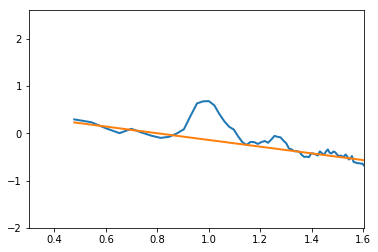

In [30]:
# Plot the fit, with osc excluded (note: plots original PSD with oscs included)
plt_psd_2(freqs, psd, freqs_excl, np.power(10, expf(freqs_excl, *fit_exp_excl)))

# Compare Fits


In [31]:
# Print out results across all the different approaches
print('FIT RESULTS \n')
print('OLS: \t\t\t', res_ols)
print('RLM: \t\t\t', res_rlm)
print('RLM-Exclude Alpha:\t', res_rlm_alph)
print('RLM-Exclude Oscs:\t', res_rlm_excl)
print('RANSAC:\t\t\t', res_ran)
print('RANSAC-Exclude Alpha:\t', res_ran_alph)
print('RANSAC-Exclude Oscs:\t', res_ran_excl)
print('EXP: \t\t\t', res_exp)
print('EXP-Exclude Alpha:\t', res_exp_alph)
print('EXP-Exclude Oscs:\t', res_exp_excl)
print('FOOOF:\t\t\t', res_fooof)

FIT RESULTS 

OLS: 			 -0.9330609141859382
RLM: 			 -0.8133822433582695
RLM-Exclude Alpha:	 -0.7228972545346237
RLM-Exclude Oscs:	 -0.7087758083697184
RANSAC:			 -0.760663273245583
RANSAC-Exclude Alpha:	 -0.7251119906528884
RANSAC-Exclude Oscs:	 -0.7576999379707514
EXP: 			 -0.9330609131352398
EXP-Exclude Alpha:	 -0.7264636284120363
EXP-Exclude Oscs:	 -0.7099949804395156
FOOOF:			 -0.6997273712601355


In [32]:
# Order fits by magnitude
all_res_fits = [(res_ols, 'OLS'), (res_fooof, 'FOOOF'),
               (res_rlm, 'RLM'), (res_rlm_alph, 'RLM-EA'), (res_rlm_excl, 'RLM-EO'),
               (res_ran, 'RAN'), (res_ran_alph, 'RAN-EA'), (res_ran_excl, 'RAN-EO'),
               (res_exp, 'EXP'), (res_exp_alph, 'EXP-EA'), (res_exp_excl, 'EXP-EO')]
all_res_fits.sort()
all_res_fits.reverse()

# Print out in order of fit magnitude
print('FIT RESULTS (SORTED):')
for fit in all_res_fits:
    print('\t {:1.5f} \t {}'.format(*fit))

FIT RESULTS (SORTED):
	 -0.69973 	 FOOOF
	 -0.70878 	 RLM-EO
	 -0.70999 	 EXP-EO
	 -0.72290 	 RLM-EA
	 -0.72511 	 RAN-EA
	 -0.72646 	 EXP-EA
	 -0.75770 	 RAN-EO
	 -0.76066 	 RAN
	 -0.81338 	 RLM
	 -0.93306 	 EXP
	 -0.93306 	 OLS
